In [1]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg as linalg
from matplotlib import pyplot as plt
%matplotlib inline

$$ \beta = \frac{\kappa \Delta t}{(\Delta x)^2} $$

Mark Speigelman's notes: http://www.ldeo.columbia.edu/~mspieg/mmm/Diffusion.pdf

Forward time centered space 

$$ T^{n+1}_j = T^n_j + \beta [1 \ \ -2  \ \ \ 1 ] T^n_j  = [\beta \ \ \ (1-2\beta)  \ \ \ \beta ] T^n_j$$

Fully implicit

$$ [ -\beta \ \ \ \ (1 + 2 \beta) \ \ -\beta ] T^{n+1}_j = T^n_j $$

Crank Nicholson

$$ [ -\beta \ \ \ \ 2(1 + \beta) \ \ -\beta ] T^{n+1}_j = [ \beta \ \ \ \ 2(1 - \beta) \ \ \ \beta ] T^n_j $$

We define 

$$ C = [ -\beta \ \ \ \ 2(1 + \beta) \ \ -\beta ] $$

and 

$$ D = [ \beta \ \ \ \ 2(1 - \beta) \ \ \ \beta ] $$

giving 

$$ C  T^{n+1}_j = D T^n_j  $$

or 

$$ T^{n+1}_j = C^{-1} D T^n_j $$

In [269]:
n = 100

dt = 1
dx = 1

# make kappa dependent on space
# diffusivities and fluxes are defined at in-between points
# endpoint values are never actually used, overwritten by b/c

# linearly increasing
#kappa = np.linspace(0.5, 0.1, n+1)
# piecewise constant
kappa = np.full(n+1, 0.1)
kappa[3*n/4:] = 0.5

# at the faces
beta = kappa * dt / dx**2

# create sparse matrices

# implicit stencil
C = (sparse.diags(-beta[1:-1], -1) +
     sparse.diags(2 + beta[1:] + beta[:-1], 0) +
     sparse.diags(-beta[1:-1], 1)).tolil()

# forward stencil
D = (sparse.diags(beta[1:-1], -1) +
     sparse.diags(2 - beta[1:] - beta[:-1], 0) +
     sparse.diags(beta[1:-1], 1)).tolil()

# fill in boundary conditions
#upper
C[0,0] = 2 + beta[1]
C[0,1] = -beta[1]
D[0,0] = 2 - beta[1]
D[0,1] = beta[1]
#lower
C[-1,-1] = 2 + beta[-2]
C[-1,-2] = - beta[-2]
D[-1,-1] = 2 - beta[-2]
D[-1,-2] = beta[-2]

# forcing vector
# should be scaled by dt and dx
f = np.zeros(n)
f[-1] = 0.1

C = C.tocsc()
D = D.tocsc()

A = linalg.inv(C).dot(D).tocsr()

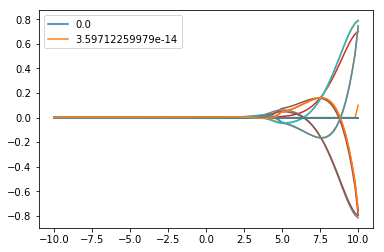

In [275]:
x = np.linspace(-10, 10, n)
#g = np.exp(-(x-10)**2)
g = np.zeros(n)

gn = g.copy()
for nt in range(1001):
    gn = A.dot(gn) + f*np.cos(np.pi * nt / 200)
    if nt%100 == 0:
        plt.plot(x, g)
        plt.plot(x, gn)
        plt.legend([g.sum(), gn.sum()])


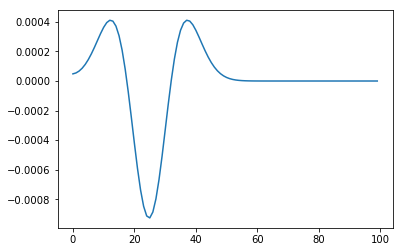

In [153]:
plt.plot((A - sparse.eye(n)).dot(fn))


In [154]:
D[0,:5].toarray()

array([[ 1.9,  0.1,  0. ,  0. ,  0. ]])

In [155]:
C[:5,:5].toarray()

array([[ 2.1, -0.1,  0. ,  0. ,  0. ],
       [-0.1,  2.2, -0.1,  0. ,  0. ],
       [ 0. , -0.1,  2.2, -0.1,  0. ],
       [ 0. ,  0. , -0.1,  2.2, -0.1],
       [ 0. ,  0. ,  0. , -0.1,  2.2]])

In [51]:
fn.sum()

8.7736465619822663

In [52]:
f.sum()

8.7736465619823036

In [59]:
C[2,3] = 10